# Imports:

In [1]:
# Makes sure to reload modules when they change
%load_ext autoreload
%autoreload 2

# --- Standard Library Imports ---
import os
import joblib
from PIL import Image, ImageOps

# --- Third-Party Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.amp import GradScaler, autocast

import torch

# --- Custom Imports ---
from src.utils import (
    extractCoordinates,
    aspect_crop,
    haversine_distance,
    plot_images_from_dataloader,
    setup_TensorBoard_writers,
    log_error_map,
)

from src.dataset import GeolocalizationDataset
from src.models import MultiTaskDINOGeo

torch.backends.cudnn.benchmark = True

# Image preprocessing:

In [2]:
# Setup paths
RAW_IMAGE_FOLDER = r"data_manual_gps_united"             # Use original images for GPS extraction
PROCESSED_IMAGE_FOLDER = r"data_processed_manual_gps" # Use processed images for training

if not os.path.exists(PROCESSED_IMAGE_FOLDER) or len(os.listdir(PROCESSED_IMAGE_FOLDER)) < 1475:
    os.makedirs(PROCESSED_IMAGE_FOLDER, exist_ok=True)

    print("Starting Pre-processing...")
    files = [f for f in os.listdir(RAW_IMAGE_FOLDER) if f.lower().endswith(('.jpg', '.jpeg'))]

    for filename in tqdm(files):
        src_path = os.path.join(RAW_IMAGE_FOLDER, filename)
        dst_path = os.path.join(PROCESSED_IMAGE_FOLDER, filename)
        
        try:
            with Image.open(src_path) as img:
                img = ImageOps.exif_transpose(img)
                img = img.convert('RGB')
                img = aspect_crop(img) 
                img = img.resize((192, 256), Image.Resampling.LANCZOS)
                img.save(dst_path, quality=95)
        except Exception as e:
            print(f"Failed {filename}: {e}")
else:
    print("Pre-processed images already exist. Skipping preprocessing step.")

Pre-processed images already exist. Skipping preprocessing step.


# Data loading:

In [3]:
if __name__ == "__main__":

    SCALER_SAVE_PATH = 'coordinate_scaler.pkl'
    processed_data = []

    for filename in os.listdir(RAW_IMAGE_FOLDER):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            raw_image_path = os.path.join(RAW_IMAGE_FOLDER, filename)
            processed__image_path = os.path.join(PROCESSED_IMAGE_FOLDER, filename)
            
            # Check if the processed version actually exists
            if not os.path.exists(processed__image_path):
                continue
                
            # Extract coordinates from the ORIGINAL file
            coords = extractCoordinates(raw_image_path)
            
            if coords:
                processed_data.append({
                    'path': processed__image_path, 
                    'lat': coords[0], 
                    'lon': coords[1]
                })

    df = pd.DataFrame(processed_data)
    
    # Keep 20% of the data for validation
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # Scale latitude and longitude to [0, 1] range
    # must fit on training data *only*
    scaler = MinMaxScaler()
    train_df[['lat', 'lon']] = scaler.fit_transform(train_df[['lat', 'lon']])
    val_df[['lat', 'lon']] = scaler.transform(val_df[['lat', 'lon']])

    joblib.dump(scaler, SCALER_SAVE_PATH)

## Clustering for multi-task training:

Generating Zone Labels on Normalized Data...


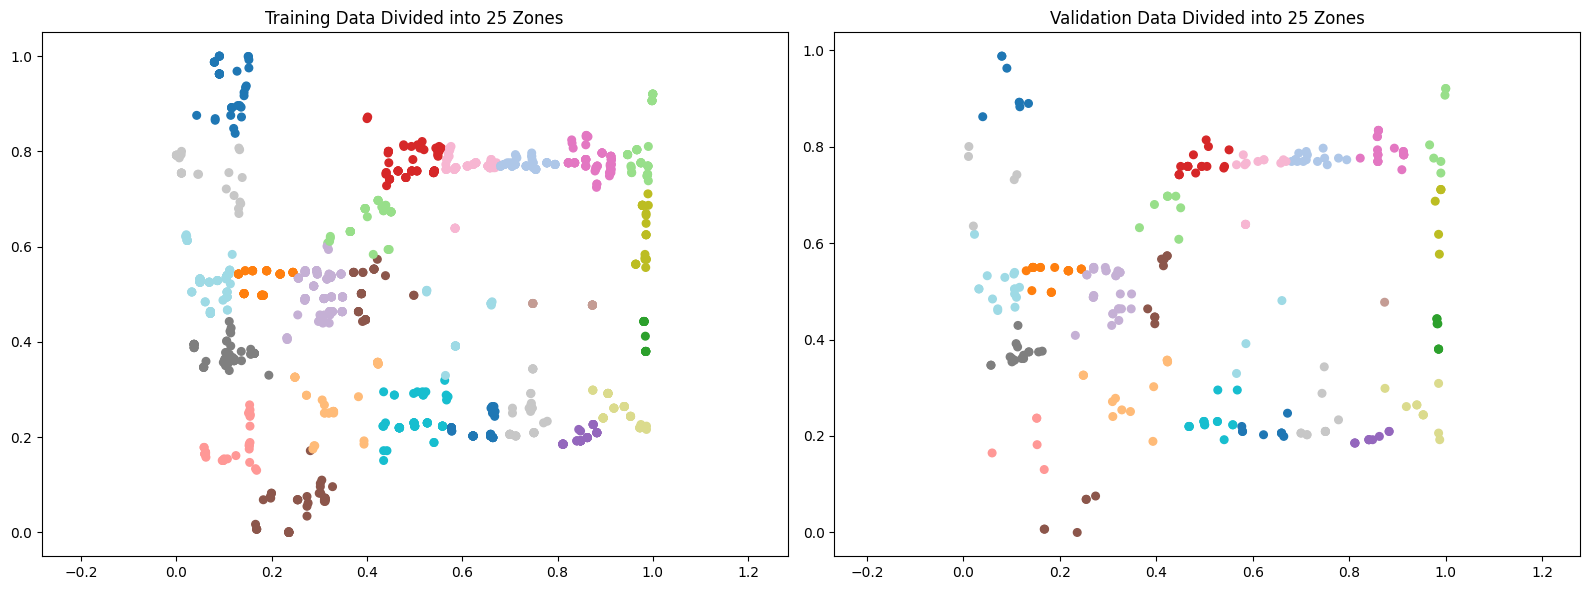

In [4]:
NUM_ZONES = 25 

print("Generating Zone Labels on Normalized Data...")
kmeans = KMeans(n_clusters=NUM_ZONES, random_state=42, n_init=10)

# Fit on the normalized coordinates
train_df['zone_label'] = kmeans.fit_predict(train_df[['lat', 'lon']])
val_df['zone_label'] = kmeans.predict(val_df[['lat', 'lon']])

# plot the zones to see if they look reasonable for both training and validation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training data plot
axes[0].scatter(train_df['lon'], train_df['lat'], c=train_df['zone_label'], cmap='tab20', s=30)
axes[0].set_title(f"Training Data Divided into {NUM_ZONES} Zones")
axes[0].axis('equal')  # Keep aspect ratio so it looks like a map

# Validation data plot
axes[1].scatter(val_df['lon'], val_df['lat'], c=val_df['zone_label'], cmap='tab20', s=30)
axes[1].set_title(f"Validation Data Divided into {NUM_ZONES} Zones")
axes[1].axis('equal')  # Keep aspect ratio so it looks like a map

plt.tight_layout()
plt.show()

# Data loading:

Initializing train dataset...
Caching 1180 images in RAM...


100%|██████████| 1180/1180 [00:20<00:00, 58.11it/s]


Initializing validation dataset...
Caching 295 images in RAM...


100%|██████████| 295/295 [00:05<00:00, 56.58it/s]


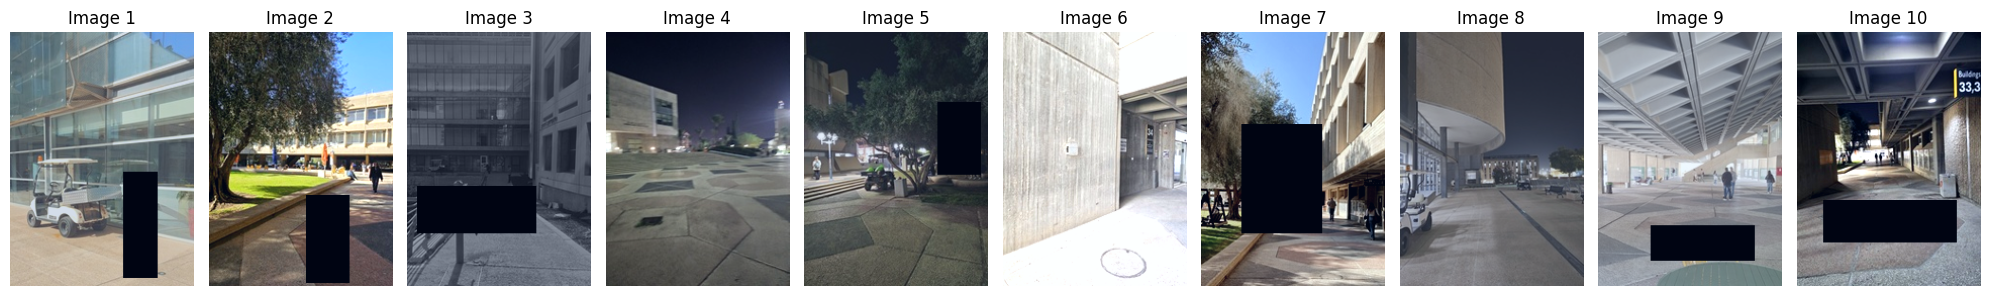

In [5]:
if __name__ == "__main__":
    print("Initializing train dataset...")
    train_dataset = GeolocalizationDataset(
        image_paths=train_df["path"].tolist(),
        coordinates=train_df[["lat", "lon"]].values,
        zone_labels=train_df["zone_label"].values,
        is_train=True,
        target_size=(252, 182),
    )
    print("Initializing validation dataset...")
    val_dataset = GeolocalizationDataset(
        image_paths=val_df["path"].tolist(),
        coordinates=val_df[["lat", "lon"]].values,
        zone_labels=val_df["zone_label"].values,
        is_train=False,
        target_size=(252, 182),
    )

    train_loader = DataLoader(
        train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=False
    )

    plot_images_from_dataloader(train_loader)

# Model setup:

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
is_rtx = "RTX" in torch.cuda.get_device_name(0)
print("Using device:", device)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))

model = MultiTaskDINOGeo(NUM_ZONES).to(device)

if is_rtx:
    model = model.to(
        memory_format=torch.channels_last
    )  # Optimize for modern GPUs that prefer channels_last
else:
    print("RTX card not detected: Disabling AMP/Channels_Last optimizations")
    model = model.to(device)

# Training Hyperparameters
UNFREEZE_INTERVAL = 20  # epochs between unfreezing backbone blocks
BLOCKS_PER_STEP = 1     # How many blocks to open at once
victory_lap_started = False

patience_counter = 0
early_stopping_patience = UNFREEZE_INTERVAL + 1 # stop early if no improvement before next unfreeze
epochs = 300

use_TensorBoard = True  # Set to False to disable TensorBoard logging

criterion_reg = torch.nn.HuberLoss(delta=1.0)
criterion_cls = torch.nn.CrossEntropyLoss(label_smoothing=0.15)

# Learning rates for phase 1 - iterative unfreezing
p1_base_head_lr = 1e-3
p1_backbone_lr = 5e-5

# Learning rates for phase 2 - fine-tuning all layers
p2_backbone_lr = 1e-5  
p2_head_lr = 5e-4  

optimizer = torch.optim.AdamW(
    [
        {   
            "params": filter(lambda p: p.requires_grad, model.backbone.parameters()),
            "lr": p1_backbone_lr,
        },
        {"params": model.shared.parameters(), "lr": p1_base_head_lr},
        {"params": model.reg_head.parameters(), "lr": p1_base_head_lr},
        {"params": model.cls_head.parameters(), "lr": p1_base_head_lr},
    ],
    weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=UNFREEZE_INTERVAL, T_mult=1, eta_min=1e-7)

print(f"Training on {len(train_dataset)} images, Validating on {len(val_dataset)} images.")

Using device: cuda
CUDA available: True
GPU: NVIDIA GeForce GTX 1070


Using cache found in C:\Users\013ri/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\013ri/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\013ri/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\013ri/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


RTX card not detected: Disabling AMP/Channels_Last optimizations
Training on 1180 images, Validating on 295 images.


# Model training:

In [8]:
from datetime import datetime

# For tracking metrics
train_losses = []
val_losses = []
val_avg_dist_history = []
val_median_dist_history = []
val_zone_accuracy = []
learning_rates = []

# for saving the best model
best_dist = float("inf")
best_epoch = -1
best_model_path = "trained_models/geo_model_training_in_progress.pth"

if use_TensorBoard:
    writer_train, writer_val = setup_TensorBoard_writers()

print(f"Starting training on {device}...")

# scaler for mixed precision training, prevents gradient underflow
gradScaler = GradScaler("cuda")  

try:
    for epoch in range(epochs):
        # Check for Unfreezing layer blocks
        if epoch > 0 and epoch % UNFREEZE_INTERVAL == 0 and not victory_lap_started:
            model.unfreeze_step(BLOCKS_PER_STEP)

            # Check if all blocks but the first are unfrozen - phase 2 begins
            # unfreeze the first block too and start fine-tuning
            if next(model.backbone.blocks[1].parameters()).requires_grad:
                model.unfreeze_step(BLOCKS_PER_STEP)
                print(f"\n VICTORY LAP started at Epoch {epoch} 🏆")
                victory_lap_started = True

                # Switch Optimizer to Low & Slow
                optimizer = torch.optim.AdamW(
                    [
                        {"params": model.backbone.parameters(), "lr": p2_backbone_lr},
                        {"params": model.shared.parameters(), "lr": p2_head_lr},
                        {"params": model.reg_head.parameters(), "lr": p2_head_lr},
                        {"params": model.cls_head.parameters(), "lr": p2_head_lr},
                    ],
                    weight_decay=0.02,
                )

                # Switch Scheduler to Plateau (Patience=3, Factor=0.5)
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, mode="min", factor=0.5, patience=3, verbose=True
                )

                # Tighten Early Stopping for the end game
                patience_counter = 0

            else:
                patience_counter = 0  # reset patience on unfreeze
                # rebind optimizer to capture new blocks that were unfrozen
                num_unfrozen = epoch // UNFREEZE_INTERVAL

                current_backbone_lr = p1_backbone_lr * 0.9**num_unfrozen
                current_head_lr = p1_base_head_lr * 0.95**num_unfrozen

                optimizer = torch.optim.AdamW(
                    [
                        {"params": model.backbone.parameters(), "lr": current_backbone_lr},
                        {"params": model.shared.parameters(), "lr": current_head_lr},
                        {"params": model.reg_head.parameters(), "lr": current_head_lr},
                        {"params": model.cls_head.parameters(), "lr": current_head_lr},
                    ],
                    weight_decay=0.01,
                )

                # Restart scheduler with the new, lower ceiling
                scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                    optimizer, T_0=UNFREEZE_INTERVAL, T_mult=1, eta_min=1e-7
                )
                print("--- Optimizer & Scheduler Reset for New Backbone Blocks ---")

        # Training Phase
        model.train()  # Dropout ON
        train_running_loss = 0.0

        pbar = tqdm(
            train_loader,
            desc=f"Epoch {epoch + 1}/{epochs}",
            leave=False,
            unit="batch",
            mininterval=0.5,
        )

        for batch_idx, (images, labels_coords, labels_zones) in enumerate(pbar):
            # non_blocking=True speeds up RAM-to-VRAM transfer
            images = images.to(device, non_blocking=True)
            labels_coords = labels_coords.to(device, non_blocking=True)
            labels_zones = labels_zones.to(device, non_blocking=True)

            if is_rtx:  # Optimize for RTX GPUs that prefer channels_last
                images = images.to(memory_format=torch.channels_last)

            optimizer.zero_grad(set_to_none=True)

            if is_rtx:  # Use Mixed Precision Training only on RTX cards
                with autocast("cuda", dtype=torch.float16):
                    pred_coords, pred_zones = model(images)

                    loss_reg = criterion_reg(pred_coords, labels_coords)
                    loss_cls = criterion_cls(pred_zones, labels_zones)

                    loss = loss_reg + (0.5 * loss_cls)

                gradScaler.scale(loss).backward()
                gradScaler.step(optimizer)
                gradScaler.update()

            else:  # Standard training for non-RTX cards
                pred_coords, pred_zones = model(images)

                loss_reg = criterion_reg(pred_coords, labels_coords)
                loss_cls = criterion_cls(pred_zones, labels_zones)

                loss = loss_reg + (0.5 * loss_cls)

                loss.backward()
                optimizer.step()

            # Step the cosine annealing scheduler 
            if not victory_lap_started:
                scheduler.step(epoch + batch_idx / len(train_loader))
            train_running_loss += loss.item()

        # Validation Phase
        model.eval()  # Set model to evaluation mode (disables Dropout)
        val_running_loss = 0.0
        correct_zones = 0
        raw_preds_coords = []
        raw_trues_coords = []

        with torch.no_grad(): 
            for images, labels_coords, labels_zones in val_loader:
                images = images.to(device, non_blocking=True)
                labels_coords = labels_coords.to(device, non_blocking=True)
                labels_zones = labels_zones.to(device, non_blocking=True)

                # Standard Prediction and Loss Calculation
                pred_coords, pred_zones = model(images)
                loss_reg = criterion_reg(pred_coords, labels_coords)
                loss_cls = criterion_cls(pred_zones, labels_zones)
                val_running_loss += (loss_reg + 0.5 * loss_cls).item()

                raw_preds_coords.append(pred_coords.cpu().numpy())
                raw_trues_coords.append(labels_coords.cpu().numpy())

                predicted_zones = torch.argmax(pred_zones, dim=1)
                correct_zones += (predicted_zones == labels_zones).sum().item()

        # Concatenate all batches, convert to real-world coordinates
        full_preds_raw = np.vstack(raw_preds_coords)
        full_trues_raw = np.vstack(raw_trues_coords)
        real_preds = scaler.inverse_transform(full_preds_raw)
        real_trues = scaler.inverse_transform(full_trues_raw)

        # Calculate distance errors
        distances = haversine_distance(real_preds, real_trues)
        avg_dist_error = np.mean(distances)

        if victory_lap_started:# ReduceLROnPlateau step
            scheduler.step(avg_dist_error)  

        median_dist_error = np.median(distances)
        zone_accuracy = correct_zones / len(val_dataset) * 100.0
        avg_train_loss = train_running_loss / len(train_loader)
        avg_val_loss = val_running_loss / len(val_loader)

        if victory_lap_started:
            current_lr = optimizer.param_groups[0]["lr"]
        else:
            current_lr = scheduler.get_last_lr()[0]

        if use_TensorBoard:  # Write to TensorBoard
            writer_train.add_scalar("MSE Loss", avg_train_loss, epoch)
            writer_val.add_scalar("MSE Loss", avg_val_loss, epoch)
            writer_val.add_scalar(
                "Metrics/Avg_distance_Error_Meters", avg_dist_error, epoch
            )
            writer_val.add_scalar(
                "Metrics/Median_distance_Error_Meters", median_dist_error, epoch
            )
            writer_val.add_scalar("Metrics/Zone_Accuracy_Percent", zone_accuracy, epoch)
            writer_train.add_scalar("Hyperparameters/Learning_Rate", current_lr, epoch)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_avg_dist_history.append(avg_dist_error)
        val_median_dist_history.append(median_dist_error)
        val_zone_accuracy.append(zone_accuracy)
        learning_rates.append(current_lr)

        print(
            f"Epoch {epoch + 1}: Train Loss {avg_train_loss:.4f} | Val Loss {avg_val_loss:.4f} | "
            f"Avg Dist Error {avg_dist_error:.1f}m | Median Dist Error {median_dist_error:.1f}m | Zone Acc {zone_accuracy:.1f}%"
        )

        # Save the best version of the model
        if avg_dist_error < best_dist:
            best_dist = avg_dist_error
            best_epoch = epoch + 1

            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
            print(f"  *** NEW BEST: {best_dist:.1f}m ***")

        else:
            patience_counter += 1
            print(f"(No improvement for {patience_counter}/{early_stopping_patience} epochs)")

            # Early Stopping check
            if patience_counter >= early_stopping_patience:
                print("Model stopped improving. Ending training early.")
                break

except KeyboardInterrupt:
    print("\n\nTraining Interrupted by User. Saving current progress...")

# Rename the best model file to a descriptive name
if os.path.exists(best_model_path):
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    final_name = f"trained_models/geo_model_epoch_{best_epoch}_mean_{best_dist:.2f}_{current_time}.pth"
            
    # Rename the temp file
    os.rename(best_model_path, final_name)
    print(f"\n Best model saved to: {final_name}")

if use_TensorBoard:
    writer_train.close()
    writer_val.close()

Tensorboard - Logging to: runs/experiment_20260127_175429
Starting training on cuda...


Epoch 1: Train Loss 0.7610 | Val Loss 1.0273 | Avg Dist Error 28.0m | Median Dist Error 23.3m | Zone Acc 51.2%
  *** NEW BEST: 28.0m ***


Epoch 2: Train Loss 0.6848 | Val Loss 1.0259 | Avg Dist Error 24.8m | Median Dist Error 21.3m | Zone Acc 51.5%
  *** NEW BEST: 24.8m ***


Epoch 3: Train Loss 0.6189 | Val Loss 1.0241 | Avg Dist Error 24.7m | Median Dist Error 20.5m | Zone Acc 51.9%
  *** NEW BEST: 24.7m ***


Epoch 4: Train Loss 0.5787 | Val Loss 1.0445 | Avg Dist Error 29.6m | Median Dist Error 25.3m | Zone Acc 53.6%
(No improvement for 1/21 epochs)




Training Interrupted by User. Saving current progress...

 Best model saved to: trained_models/geo_model_epoch_3_mean_24.74_20260127_175509.pth
